In [ ]:
%%capture install_log
!apt-get install libsox-fmt-all libsox-dev sox
!pip install sox pytube pydub crepe transformers torchtext==0.12.0 pyannote.audio

In [ ]:
#check that we have GPU acceleration enabled

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3ac5fead-9a1f-746f-5800-2a304ad409c3)


### Download and Prepare the Data

In [ ]:
import os
import re
import sox
import librosa
from pytube import YouTube
from pydub import AudioSegment
from IPython.display import Audio, display

In [ ]:
def retrieve_audio(video_link, output_dir):

    ROOT = os.getcwd()
    output = os.path.join(ROOT, output_dir)
    os.makedirs(output, exist_ok=True)
    
    try:
        video = YouTube(video_link)

        audio = video.streams.filter(only_audio=True, file_extension='mp4').first()

        audio.download(output_dir)
    
    except:
        print("Connection error")

#add logic so it only downloads once

In [ ]:
#add denoising here as it becomes available

def convert_to_wav(input_path, output_dir):
    
    ROOT = os.getcwd()
    output = os.path.join(ROOT, output_dir)
    os.makedirs(output, exist_ok=True)

    file_name = re.split("/|\.", input_path)[-2]

    audio = AudioSegment.from_file(input_path)
    audio.export(f"{output_dir}/{file_name}.wav", format='wav')

In [ ]:
retrieve_audio("https://www.youtube.com/watch?v=jlJijwgtgzI", "tmp")
convert_to_wav('tmp/A Panel Discussion on Climate Change in New England.mp4', "input")
DEMO_FILE = {'name': "A Panel Discussion on Climate Change in New England", 'audio': "input/A Panel Discussion on Climate Change in New England.wav"}

In [ ]:
#I've used a 30 sec excerpt from a separate video featuring the moderator of the debate, Anthony Leiserowitz, as a speaker sample

retrieve_audio("https://www.youtube.com/watch?v=6ObqydfPGLI", "tmp")
convert_to_wav('tmp/Yale Professor Tony Leiserowitz Discusses American Perceptions of Climate Change.mp4', "tmp")
tfm = sox.Transformer()
tfm.trim(10, 40)
tfm.build_file('tmp/Yale Professor Tony Leiserowitz Discusses American Perceptions of Climate Change.wav', "input/speaker_sample.wav")
speaker_sample = "input/speaker_sample.wav"

In [ ]:
SAMPLE_RATE=16000
audio, sr = librosa.load(speaker_sample, sr=SAMPLE_RATE)

display(Audio(audio, rate=sr))

## Generate the Diarized Transcript

In [ ]:
import torch
import numpy as np
import pandas as pd
from pyannote.audio import Pipeline
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [ ]:
#To be able to use the diarization pipeline from pyannote go to https://github.com/pyannote/pyannote-audio and follow the instructions

auth_token=#put your huggingface authorization token here

diarization_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=auth_token) #finalized diarization model

asr_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h-lv60-self") #we'll replace this base model with a fine-tuned one once it becomes available
asr_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/318 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/162 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


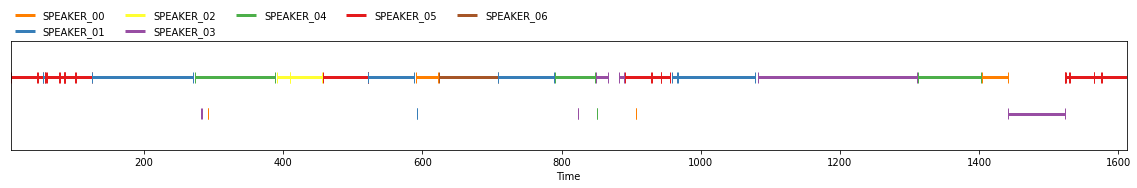

In [ ]:
# we can start off by visualizing the conversation; Anthony Leiserowitz is SPEAKER_04

diarization = diarization_pipeline(DEMO_FILE)
diarization

In [ ]:
turns = pd.DataFrame(columns=['speaker', 'start_time', 'end_time'])
for turn, _, speaker in diarization.itertracks(yield_label=True):
        turns = turns.append({'speaker' : speaker, 'start_time' : turn.start, 'end_time' : turn.end}, ignore_index=True)

speakers = {speaker : i for i, speaker in enumerate(sorted(turns.speaker.unique()))}

turns['speaker'].replace(speakers.keys(), speakers.values(), inplace=True)

turns

,speaker,start_time,end_time
0,5,8.277188,46.313438
1,5,47.359688,54.514688
2,1,54.514688,57.484688
3,5,57.704063,59.729063
4,5,61.079063,78.375938
5,5,79.000313,84.822187
6,5,85.463437,85.615313
7,5,86.509687,100.971563
8,5,101.747812,124.748438
9,1,125.254688,270.430313


In [ ]:
def diarization_profiler(file, pipeline):

  """
  This function diarizes the provided audio file and calculates some summary statistics about each turn, which are stored in the dataframes c_turns and turn_profile
  """

  diarization = pipeline(file['audio'])

  turns = pd.DataFrame(columns=['speaker', 'start_time', 'end_time'])

  for turn, _, speaker in diarization.itertracks(yield_label=True):
        turns = turns.append({'speaker' : speaker, 'start_time' : turn.start, 'end_time' : turn.end}, ignore_index=True)

  speakers = {speaker : i for i, speaker in enumerate(sorted(turns.speaker.unique()))}

  turns['speaker'].replace(speakers.keys(), speakers.values(), inplace=True)

  ignore_silence_duration = 2.0
  turns.sort_values(by=['start_time'], ascending=True, inplace=True)
  n_speakers = len(turns.speaker.unique())

  c_turns = pd.DataFrame(columns=["speaker", "start_time", "end_time", "turn_type", "gap"])
  last_speech = np.empty((n_speakers, 3))
  last_speech[:, :] = -1
  insert_count = 0
  turn_type = ""
  mutual_silence = 0.0

  for index, row in turns.iterrows():
    gap = 0.0
    other_speakers = [i for i in range(n_speakers) if i != int(row.speaker)]  

    if (((~(last_speech[other_speakers, 1] > row.start_time)).all()) and 
        ((row.start_time - last_speech[int(row.speaker), 1]) < ignore_silence_duration) and 
        (last_speech[int(row.speaker), 1] > 0)
        ): 
          c_turns.loc[int(last_speech[int(row.speaker), 2]), "end_time"] = row.end_time
          last_speech[int(row.speaker), 1] = row.end_time

    else:
        if insert_count == 0:
            turn_type = "LAUNCH"
        elif np.sum([True for x in last_speech[other_speakers] if (row.start_time < x[1] and row.end_time >= x[1]) ]) > 0:
            turn_type = "INTERRUPTION"
        elif np.sum([True for x in last_speech[other_speakers] if (row.start_time < x[1] and row.end_time <= x[1]) ]) > 0:
            turn_type = "OVERLAP"
        elif np.argmax(last_speech[:, 1]) == row.speaker:
            turn_type = "CONTINUE"
            gap = row.start_time - np.max(last_speech[:, 1])
            mutual_silence += row.start_time - np.max(last_speech[:, 1])
        else:
            turn_type = "RESPONSE"
            gap = row.start_time - np.max(last_speech[:, 1])
            if row.start_time - np.max(last_speech[:, 1]) > ignore_silence_duration:
                mutual_silence += row.start_time - np.max(last_speech[:, 1])
            
        c_turns = c_turns.append({"speaker": int(row.speaker), 
                                  "start_time": row.start_time, 
                                  "end_time": row.end_time, 
                                  "turn_type": turn_type,
                                  "gap" : gap}, 
                                 ignore_index=True)
        last_speech[int(row.speaker)] = [row.start_time, row.end_time, insert_count]
        insert_count += 1

  c_turns["duration"] = c_turns["end_time"] - c_turns["start_time"]

  turn_profile = pd.DataFrame(columns=["speaker"])

  if n_speakers == 1:
    audio_type = "SOLO"
    mutual_silence = np.nan
  else:
    audio_type = "GROUP"
    
  turn_profile["speaker"] = [i for i in range(n_speakers)]
  turn_profile["audio_type"] = audio_type
  turn_profile["total_turn_duration"] = c_turns.groupby(by="speaker").duration.sum()
  turn_profile["turn_duration"] = [c_turns[(c_turns.speaker==x)].duration.describe().to_dict() for x in turn_profile.index]
  turn_profile["speaking_percent"] = np.divide(turn_profile.total_turn_duration, c_turns.duration.sum())
  turn_profile["mutual_silence"] = mutual_silence
  turn_profile["response_time"] = [c_turns[(c_turns.speaker==x) & (c_turns.turn_type=="RESPONSE")].gap.describe().to_dict() for x in turn_profile.index]
  turn_profile["interruptions"] = [c_turns[(c_turns.speaker==x) & (c_turns.turn_type=="INTERRUPTION")].duration.describe().to_dict() for x in turn_profile.index]
  turn_profile["overlap_duration"] = [c_turns[(c_turns.speaker==x) & (c_turns.turn_type=="OVERLAP")].duration.sum() for x in turn_profile.index]
  turn_profile["overlap"] = [c_turns[(c_turns.speaker==x) & (c_turns.turn_type=="OVERLAP")].duration.describe().to_dict() for x in turn_profile.index]


  return c_turns, turn_profile

In [ ]:
c_turns, turn_profile = diarization_profiler(DEMO_FILE, diarization_pipeline)

In [ ]:
c_turns

,speaker,start_time,end_time,turn_type,gap,duration
0,5,8.277188,54.514688,LAUNCH,0.000000,46.237500
1,1,54.514688,57.484688,RESPONSE,0.000000,2.970000
2,5,57.704063,124.748438,RESPONSE,0.219375,67.044375
3,1,125.254688,270.430313,RESPONSE,0.506250,145.175625
4,4,273.045938,388.724063,RESPONSE,2.615625,115.678125
5,3,282.495938,283.289062,OVERLAP,0.000000,0.793125
6,0,291.642188,291.979688,OVERLAP,0.000000,0.337500
7,2,391.407188,455.110313,RESPONSE,2.683125,63.703125
8,5,457.236563,522.002813,RESPONSE,2.126250,64.766250
9,1,522.002813,587.309063,RESPONSE,0.000000,65.306250


In [ ]:
turn_profile

,speaker,audio_type,total_turn_duration,turn_duration,speaking_percent,mutual_silence,response_time,interruptions,overlap_duration,overlap
0,0,GROUP,69.221250,"{'count': 4.0, 'mean': 17.305312499999985, 'st...",0.044381,37.8675,"{'count': 2.0, 'mean': 2.7421875, 'std': 1.873...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.506250,"{'count': 2.0, 'mean': 0.2531249999999545, 'st..."
1,1,GROUP,413.471250,"{'count': 6.0, 'mean': 68.91187500000002, 'std...",0.265099,37.8675,"{'count': 5.0, 'mean': 0.7728749999999934, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.135000,"{'count': 1.0, 'mean': 0.1349999999999909, 'st..."
2,2,GROUP,63.703125,"{'count': 1.0, 'mean': 63.703125, 'std': nan, ...",0.040843,37.8675,"{'count': 1.0, 'mean': 2.6831249999999613, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':..."
3,3,GROUP,336.571875,"{'count': 6.0, 'mean': 56.09531249999995, 'std...",0.215794,37.8675,"{'count': 2.0, 'mean': 2.7928125000001387, 'st...","{'count': 1.0, 'mean': 81.87750000000005, 'std...",0.928125,"{'count': 2.0, 'mean': 0.46406249999998295, 's..."
4,4,GROUP,263.806875,"{'count': 4.0, 'mean': 65.95171875000003, 'std...",0.169141,37.8675,"{'count': 3.0, 'mean': 1.8562500000000075, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.337500,"{'count': 1.0, 'mean': 0.33749999999997726, 's..."
5,5,GROUP,329.113125,"{'count': 6.0, 'mean': 54.85218750000001, 'std...",0.211012,37.8675,"{'count': 4.0, 'mean': 0.9112500000000203, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':..."
6,6,GROUP,83.801250,"{'count': 1.0, 'mean': 83.80124999999998, 'std...",0.053729,37.8675,"{'count': 1.0, 'mean': 2.261250000000018, 'std...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':..."


In [ ]:
def get_turns(file, c_turns, processor, model, offset=0, samplerate=16000):

 """
  This function consolidates consecutive turns with the same speaker into a single turn on the basis of c_turns and generates the corresponding audio files and transcriptions
  """

  ROOT = os.getcwd()
  tmp_dir = os.path.join(ROOT, 'tmp')
  os.makedirs(tmp_dir, exist_ok=True)

  model.eval()
  
  for index, row in c_turns.iterrows():
    tfm = sox.Transformer()
    tfm.trim(row.start_time - offset, row.end_time + offset)
    tfm.build_file(f"input/{file['name']}.wav", f"tmp/{file['name']}_turn_{index}.wav")
    audio, sr = librosa.load(f"tmp/{file['name']}_turn_{index}.wav", sr=samplerate)

    c_turns.loc[index, "audio_file"] = f"tmp/{file['name']}_turn_{index}.wav"

    with torch.no_grad():
      input_values = processor(audio, return_tensors="pt", padding="longest", sampling_rate=samplerate).input_values
      logits = model(input_values).logits
      predicted_ids = torch.argmax(logits, dim=-1)
      pred_transcript = processor.batch_decode(predicted_ids)

      #torch.cuda.empty_cache() --clear memory if using GPU acceleration
      #spellcheck goes here if necessary  

      c_turns.loc[index, "transcript"] = pred_transcript[0].lower()
  
  return c_turns

In [ ]:
c_turns = get_turns(DEMO_FILE, c_turns, asr_processor, asr_model, .1)

c_turns

,speaker,start_time,end_time,turn_type,gap,duration,audio_file,transcript
0,5,8.277188,54.514688,LAUNCH,0.000000,46.237500,tmp/A Panel Discussion on Climate Change in Ne...,so it's been interesting looking at them comin...
1,1,54.514688,57.484688,RESPONSE,0.000000,2.970000,tmp/A Panel Discussion on Climate Change in Ne...,ta thats that's why we have questions from the...
2,5,57.704063,124.748438,RESPONSE,0.219375,67.044375,tmp/A Panel Discussion on Climate Change in Ne...,i'll give them to you ah my question would be ...
3,1,125.254688,270.430313,RESPONSE,0.506250,145.175625,tmp/A Panel Discussion on Climate Change in Ne...,let me just start by saying two things about t...
4,4,273.045938,388.724063,RESPONSE,2.615625,115.678125,tmp/A Panel Discussion on Climate Change in Ne...,will i was going to agree with the senator her...
5,3,282.495938,283.289062,OVERLAP,0.000000,0.793125,tmp/A Panel Discussion on Climate Change in Ne...,over twenty thirty
6,0,291.642188,291.979688,OVERLAP,0.000000,0.337500,tmp/A Panel Discussion on Climate Change in Ne...,many of these
7,2,391.407188,455.110313,RESPONSE,2.683125,63.703125,tmp/A Panel Discussion on Climate Change in Ne...,i think congress looked at the problem nationa...
8,5,457.236563,522.002813,RESPONSE,2.126250,64.766250,tmp/A Panel Discussion on Climate Change in Ne...,soas there'se more that people want to say abo...
9,1,522.002813,587.309063,RESPONSE,0.000000,65.306250,tmp/A Panel Discussion on Climate Change in Ne...,part of it is making people that don't live on...


In [ ]:
#may not even be necessary after all, but if it is add logic to prevent overwriting

def get_diarized_transcript(c_turns, display=False):
  """
  This function takes the c_turns DataFrame and generates a diarized transcript of the conversation, which is saved in the output directory
  """
    
  ROOT = os.getcwd()
  output_dir = os.path.join(ROOT, 'output')
  os.makedirs(output_dir, exist_ok=True)
    
  with open(f"output/{DEMO_FILE['name']}_transcript.txt", "a") as file:
    for index, row in c_turns.iterrows():
      file.writelines(f"Speaker {row.speaker}: {row.transcript}\n") 
    
  if display:
    with open(f"output/{DEMO_FILE['name']}_transcript.txt", "r") as file:
      for line in file:
        print(line)

In [ ]:
get_diarized_transcript(c_turns, display=True)

Speaker 4: so it's been interesting looking at them coming in and it looks like they basically break into two major groups the first being ah this question of adaptation how do we respond right here in new england to these kinds of impacts the other man a theme that's very clear is people wanting to move very quickly beyond this question of adaptation to mitigation a given the scale and size of the impacts and the warming that we're now expecting a some many people in the audience are actually quite interested in moving onto well what do we do to prevent these changes to begin with but let's start with the adaptation side and there's a number of comments here that are are stronger than the way i would say this o ah let me say it this way

Speaker 5: thats that's why we have questions from the audience

Speaker 4: i'll give them to you ah my question would be the giving the sea level rise ind greater storm surges now expected in the future how should we be rethinking coastal zoning poli

The transcript looks pretty good, but could definitely be improved. Fine-tuning the ASR model or adding a language model like BERT on top of it would help in this regard.



## Extract Speaker-Level Audio and Text

In [ ]:
def get_speaker_data(c_turns, turn_profile):

  """
  This function extracts speaker-level audio and text data from the list of turns and appends it to the turn_profile DataFrame
  """

  for index, row in turn_profile.iterrows():

      turn_profile.loc[index, "transcript"] = " ".join(c_turns[c_turns.speaker == index]['transcript'].to_list())

      audio_files = c_turns[c_turns.speaker == index]['audio_file'].to_list()

      if len(audio_files) > 1:

        cbn =  sox.Combiner()
        cbn.build(audio_files, f"tmp/speaker_{index}.wav", "concatenate")

      else:

        tfm = sox.Transformer()
        tfm.build_file(audio_files[0], f"tmp/speaker_{index}.wav")

      turn_profile.loc[index, "audio_file"] =  f"tmp/speaker_{index}.wav"

  return turn_profile

In [ ]:
turn_profile = get_speaker_data(c_turns, turn_profile)

turn_profile

,speaker,audio_type,total_turn_duration,turn_duration,speaking_percent,mutual_silence,response_time,interruptions,overlap_duration,overlap,transcript,audio_file
0,0,GROUP,64.260000,"{'count': 2.0, 'mean': 32.129999999999995, 'st...",0.041313,39.58875,"{'count': 1.0, 'mean': 2.716875000000016, 'std...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.590625,"{'count': 1.0, 'mean': 0.5906249999999886, 'st...",twenty thirty i think congress looked at the p...,tmp/speaker_0.wav
1,1,GROUP,67.921875,"{'count': 2.0, 'mean': 33.9609375, 'std': 5.54...",0.043667,39.58875,"{'count': 2.0, 'mean': 3.0712500000000773, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",n this life as an inland dweller myself i've o...,tmp/speaker_1.wav
2,2,GROUP,262.473750,"{'count': 3.0, 'mean': 87.49125000000002, 'std...",0.168746,39.58875,"{'count': 3.0, 'mean': 2.1881249999999377, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",well ye i was going to agree with the senator ...,tmp/speaker_2.wav
3,3,GROUP,335.508750,"{'count': 4.0, 'mean': 83.87718749999996, 'std...",0.215701,39.58875,"{'count': 3.0, 'mean': 1.8956249999999955, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",part of it may be you know rethinking how we v...,tmp/speaker_3.wav
4,4,GROUP,328.539375,"{'count': 5.0, 'mean': 65.70787499999999, 'std...",0.211220,39.58875,"{'count': 4.0, 'mean': 1.4807812500000548, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",so it's been interesting looking at them comin...,tmp/speaker_4.wav
5,5,GROUP,413.083125,"{'count': 5.0, 'mean': 82.61662500000004, 'std...",0.265574,39.58875,"{'count': 5.0, 'mean': 0.8842499999999902, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",thats that's why we have questions from the au...,tmp/speaker_5.wav
6,6,GROUP,83.649375,"{'count': 1.0, 'mean': 83.64937500000008, 'std...",0.053779,39.58875,"{'count': 1.0, 'mean': 2.3287500000000136, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",i'm from massachusetts so i think i should say...,tmp/speaker_6.wav


## Identify the User

In [ ]:
from pyannote.audio import Inference, Model
from numpy.linalg import norm

In [ ]:
inference = Inference(Model.from_pretrained("pyannote/embedding", use_auth_token=auth_token), window="whole")

Downloading:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

In [ ]:
def cosine_similarity(a, b):
  cos_sim = (a @ b.T) / (norm(a)*norm(b))
  return cos_sim
  
def calculate_distance(sample_audio, turn_profile, model):

  """
  This function identifies the speaker from the sample_audio_path with one of the speakers in the turn_profile DataFrame using the provided model."
  """

  sample_audio = model(sample_audio)

  for index, row in turn_profile.iterrows():

    turn_profile.loc[index, 'similarity'] =  cosine_similarity(sample_audio, model(row.audio_file))

  return turn_profile

In [ ]:
calculate_distance(speaker_sample, turn_profile, inference)

,speaker,audio_type,total_turn_duration,turn_duration,speaking_percent,mutual_silence,response_time,interruptions,overlap_duration,overlap,transcript,audio_file,similarity
0,0,GROUP,64.260000,"{'count': 2.0, 'mean': 32.129999999999995, 'st...",0.041313,39.58875,"{'count': 1.0, 'mean': 2.716875000000016, 'std...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.590625,"{'count': 1.0, 'mean': 0.5906249999999886, 'st...",twenty thirty i think congress looked at the p...,tmp/speaker_0.wav,0.066329
1,1,GROUP,67.921875,"{'count': 2.0, 'mean': 33.9609375, 'std': 5.54...",0.043667,39.58875,"{'count': 2.0, 'mean': 3.0712500000000773, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",n this life as an inland dweller myself i've o...,tmp/speaker_1.wav,0.050337
2,2,GROUP,262.473750,"{'count': 3.0, 'mean': 87.49125000000002, 'std...",0.168746,39.58875,"{'count': 3.0, 'mean': 2.1881249999999377, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",well ye i was going to agree with the senator ...,tmp/speaker_2.wav,0.116609
3,3,GROUP,335.508750,"{'count': 4.0, 'mean': 83.87718749999996, 'std...",0.215701,39.58875,"{'count': 3.0, 'mean': 1.8956249999999955, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",part of it may be you know rethinking how we v...,tmp/speaker_3.wav,0.069325
4,4,GROUP,328.539375,"{'count': 5.0, 'mean': 65.70787499999999, 'std...",0.211220,39.58875,"{'count': 4.0, 'mean': 1.4807812500000548, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",so it's been interesting looking at them comin...,tmp/speaker_4.wav,0.638745
5,5,GROUP,413.083125,"{'count': 5.0, 'mean': 82.61662500000004, 'std...",0.265574,39.58875,"{'count': 5.0, 'mean': 0.8842499999999902, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",thats that's why we have questions from the au...,tmp/speaker_5.wav,0.101236
6,6,GROUP,83.649375,"{'count': 1.0, 'mean': 83.64937500000008, 'std...",0.053779,39.58875,"{'count': 1.0, 'mean': 2.3287500000000136, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",i'm from massachusetts so i think i should say...,tmp/speaker_6.wav,0.140999


In [ ]:
def get_user_data(turn_profile, threshold):

  if turn_profile['similarity'].max() < threshold:
    print("User could not be identified. Please manually identify the user.")
    
  else:
    speaker_data = turn_profile[turn_profile['similarity'] == turn_profile['similarity'].max()]

  return speaker_data

In [ ]:
speaker_data = get_user_data(turn_profile, .5)

speaker_data

,speaker,audio_type,total_turn_duration,turn_duration,speaking_percent,mutual_silence,response_time,interruptions,overlap_duration,overlap,transcript,audio_file,similarity
4,4,GROUP,328.539375,"{'count': 5.0, 'mean': 65.70787499999999, 'std...",0.21122,39.58875,"{'count': 4.0, 'mean': 1.4807812500000548, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.0,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",so it's been interesting looking at them comin...,tmp/speaker_4.wav,0.638745


The model correctly identifies the user as Speaker_04--awesome!

## Extract Features


Eventually we will add functions to extract the following features from the speaker-level audio and the diarized transcript:
*   Loudness/Loudness Variation
*   Pitch/Pitch Variation
* Energy spectral flatness
* Response time - Ponniah
* Speaking percentage (length of speaker audio / length of all audio) - Ponniah
* Interruptions - Ponniah
* Total Speech Overlap - Ponniah
* Mutual Silence - Ponniah
* Speaker turn duration - Ponniah
* Rate of Speech (i.e., words per minute) -Aren
* Use of fillerwords (i.e., percentage of filler words to all words) - Aren
* Changes in Topic - Aren
* Changes in Sentiment - Aren 



## Final Pipeline

In [ ]:
import spacy
import crepe
import datetime as dt
from scipy.special import expit
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')
lang_model = spacy.load("en_core_web_sm")
topic_tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/tweet-topic-21-multi')
topic_model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/tweet-topic-21-multi')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
def get_filler_word_percent(text, lang_model):
  doc = lang_model(text)
  filler_words = [token.text for token in doc if token.pos_ == 'INTJ']
  filler_word_pr =  len(filler_words) / len(doc)
  
  return filler_word_pr

In [ ]:
def get_emotions(turn_profile, emotion_model):

  for index, row in turn_profile.iterrows():
  
    turn_profile.loc[index, 'emotions'] =  emotion_model(row.transcript[:512])[0]['label']

  return turn_profile

In [ ]:
get_emotions(turn_profile, emotion)

turn_profile

,speaker,audio_type,total_turn_duration,turn_duration,speaking_percent,mutual_silence,response_time,interruptions,overlap_duration,overlap,transcript,audio_file,similarity,emotions
0,0,GROUP,64.260000,"{'count': 2.0, 'mean': 32.129999999999995, 'st...",0.041313,39.58875,"{'count': 1.0, 'mean': 2.716875000000016, 'std...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.590625,"{'count': 1.0, 'mean': 0.5906249999999886, 'st...",twenty thirty i think congress looked at the p...,tmp/speaker_0.wav,0.066329,neutral
1,1,GROUP,67.921875,"{'count': 2.0, 'mean': 33.9609375, 'std': 5.54...",0.043667,39.58875,"{'count': 2.0, 'mean': 3.0712500000000773, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",n this life as an inland dweller myself i've o...,tmp/speaker_1.wav,0.050337,approval
2,2,GROUP,262.473750,"{'count': 3.0, 'mean': 87.49125000000002, 'std...",0.168746,39.58875,"{'count': 3.0, 'mean': 2.1881249999999377, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",well ye i was going to agree with the senator ...,tmp/speaker_2.wav,0.116609,realization
3,3,GROUP,335.508750,"{'count': 4.0, 'mean': 83.87718749999996, 'std...",0.215701,39.58875,"{'count': 3.0, 'mean': 1.8956249999999955, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",part of it may be you know rethinking how we v...,tmp/speaker_3.wav,0.069325,excitement
4,4,GROUP,328.539375,"{'count': 5.0, 'mean': 65.70787499999999, 'std...",0.211220,39.58875,"{'count': 4.0, 'mean': 1.4807812500000548, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",so it's been interesting looking at them comin...,tmp/speaker_4.wav,0.638745,approval
5,5,GROUP,413.083125,"{'count': 5.0, 'mean': 82.61662500000004, 'std...",0.265574,39.58875,"{'count': 5.0, 'mean': 0.8842499999999902, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",thats that's why we have questions from the au...,tmp/speaker_5.wav,0.101236,neutral
6,6,GROUP,83.649375,"{'count': 1.0, 'mean': 83.64937500000008, 'std...",0.053779,39.58875,"{'count': 1.0, 'mean': 2.3287500000000136, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",i'm from massachusetts so i think i should say...,tmp/speaker_6.wav,0.140999,neutral


In [ ]:
def get_turn_topics(c_turns, turn_profile, topic_tokenizer, topic_model):
  class_mapping = topic_model.config.id2label

  topic_model.eval()

  for index, row in c_turns.iterrows():
    tokens = topic_tokenizer(row.transcript[:514], return_tensors='pt')

    with torch.no_grad():
      output = topic_model(**tokens)

    scores = output[0][0].detach().numpy()
    scores = expit(scores)
    predictions = (scores >= 0.5) * 1

    topics = []

    for i in range(len(predictions)):
      if predictions[i]:
        topics.append(class_mapping[i])

    c_turns.loc[index, 'topics'] = ",".join(topics)

  responses = c_turns[(c_turns['turn_type'] == 'RESPONSE') | (c_turns['turn_type'] == 'LAUNCH')].reset_index(drop=True)

  turn_profile['topic_shifts'] = 0

  for index, row in responses.iterrows():

    if index == 0:
      pass

    else:
      if set(responses.loc[index - 1, 'topics'].split(",")).intersection(set(responses.loc[index, 'topics'].split(","))) == set(): 
        turn_profile.loc[row.speaker, 'topic_shifts'] += 1

  return c_turns, turn_profile

In [ ]:
c_turns, turn_profile = get_turn_topics(c_turns, turn_profile, topic_tokenizer, topic_model)

c_turns

,speaker,start_time,end_time,turn_type,gap,duration,audio_file,transcript,topics
0,4,8.294063,54.210938,LAUNCH,0.000000,45.916875,tmp/A Panel Discussion on Climate Change in Ne...,so it's been interesting looking at them comin...,news_&_social_concern
1,5,54.531563,57.417188,RESPONSE,0.320625,2.885625,tmp/A Panel Discussion on Climate Change in Ne...,thats that's why we have questions from the au...,news_&_social_concern
2,4,57.720938,124.731563,RESPONSE,0.303750,67.010625,tmp/A Panel Discussion on Climate Change in Ne...,i'll give them to you ah my question would be ...,news_&_social_concern
3,5,125.271563,270.396563,RESPONSE,0.540000,145.125000,tmp/A Panel Discussion on Climate Change in Ne...,let me just start by saying two things about t...,diaries_&_daily_life
4,2,273.855938,388.707188,RESPONSE,3.459375,114.851250,tmp/A Panel Discussion on Climate Change in Ne...,well ye i was going to agree with the senator ...,news_&_social_concern
5,0,282.647813,283.238438,OVERLAP,0.000000,0.590625,tmp/A Panel Discussion on Climate Change in Ne...,twenty thirty,
6,0,391.424063,455.093438,RESPONSE,2.716875,63.669375,tmp/A Panel Discussion on Climate Change in Ne...,i think congress looked at the problem nationa...,news_&_social_concern
7,4,457.253438,522.002813,RESPONSE,2.160000,64.749375,tmp/A Panel Discussion on Climate Change in Ne...,soas there's more that people want to say abou...,news_&_social_concern
8,5,522.002813,587.258438,RESPONSE,0.000000,65.255625,tmp/A Panel Discussion on Climate Change in Ne...,part of it is making people that don't live on...,news_&_social_concern
9,1,591.949688,621.987188,RESPONSE,4.691250,30.037500,tmp/A Panel Discussion on Climate Change in Ne...,n this life as an inland dweller myself i've o...,"news_&_social_concern,travel_&_adventure"


In [ ]:
turn_profile

,speaker,audio_type,total_turn_duration,turn_duration,speaking_percent,mutual_silence,response_time,interruptions,overlap_duration,overlap,transcript,audio_file,similarity,emotions,topic_shifts
0,0,GROUP,64.260000,"{'count': 2.0, 'mean': 32.129999999999995, 'st...",0.041313,39.58875,"{'count': 1.0, 'mean': 2.716875000000016, 'std...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.590625,"{'count': 1.0, 'mean': 0.5906249999999886, 'st...",twenty thirty i think congress looked at the p...,tmp/speaker_0.wav,0.066329,neutral,0
1,1,GROUP,67.921875,"{'count': 2.0, 'mean': 33.9609375, 'std': 5.54...",0.043667,39.58875,"{'count': 2.0, 'mean': 3.0712500000000773, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",n this life as an inland dweller myself i've o...,tmp/speaker_1.wav,0.050337,approval,0
2,2,GROUP,262.473750,"{'count': 3.0, 'mean': 87.49125000000002, 'std...",0.168746,39.58875,"{'count': 3.0, 'mean': 2.1881249999999377, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",well ye i was going to agree with the senator ...,tmp/speaker_2.wav,0.116609,realization,1
3,3,GROUP,335.508750,"{'count': 4.0, 'mean': 83.87718749999996, 'std...",0.215701,39.58875,"{'count': 3.0, 'mean': 1.8956249999999955, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",part of it may be you know rethinking how we v...,tmp/speaker_3.wav,0.069325,excitement,0
4,4,GROUP,328.539375,"{'count': 5.0, 'mean': 65.70787499999999, 'std...",0.211220,39.58875,"{'count': 4.0, 'mean': 1.4807812500000548, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",so it's been interesting looking at them comin...,tmp/speaker_4.wav,0.638745,approval,0
5,5,GROUP,413.083125,"{'count': 5.0, 'mean': 82.61662500000004, 'std...",0.265574,39.58875,"{'count': 5.0, 'mean': 0.8842499999999902, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",thats that's why we have questions from the au...,tmp/speaker_5.wav,0.101236,neutral,1
6,6,GROUP,83.649375,"{'count': 1.0, 'mean': 83.64937500000008, 'std...",0.053779,39.58875,"{'count': 1.0, 'mean': 2.3287500000000136, 'st...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.000000,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",i'm from massachusetts so i think i should say...,tmp/speaker_6.wav,0.140999,neutral,0


In [ ]:
def extract_audio_features(audio_file, samplerate=160000):

  audio, sr = librosa.load(audio_file, sr=samplerate)

  flatness = pd.DataFrame(librosa.feature.spectral_flatness(y=audio).T).describe().T
  loudness = pd.DataFrame(librosa.feature.rms(audio).T).describe().T
  time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)
  frequency = pd.DataFrame(frequency.T).describe().T

  return flatness, loudness, frequency

In [ ]:
flatness, loudness, frequency = extract_audio_features(speaker_data.loc[4, 'audio_file'], SAMPLE_RATE)

1030/1030 [==============================] - 18s 10ms/step


In [ ]:
def get_features(file, sample_audio, diarization_pipeline, asr_processor, asr_model, emotion_model, topic_tokenizer, topic_model, inference_model, lang_model, offset=0, samplerate=16000, display=False, threshold=.5):
 
  # denoising goes here

  c_turns, turn_profile  = diarization_profiler(file, diarization_pipeline)

  c_turns = get_turns(file, c_turns, asr_processor, asr_model, offset, samplerate)

  #spellcheck goes here

  #transcript = get_diarized_transcript(c_turns, display=False)

  turn_profile = get_speaker_data(c_turns, turn_profile)

  turn_profile = get_emotions(turn_profile, emotion_model)

  c_turns, turn_profile = get_turn_topics(c_turns, turn_profile, topic_tokenizer, topic_model)

  turn_profile = calculate_distance(sample_audio, turn_profile, inference_model)

  speaker_data = get_user_data(turn_profile, threshold).reset_index(drop=True)
  
  flatness, loudness, frequency = extract_audio_features(speaker_data.loc[0, 'audio_file'], samplerate)

  features = {}

  features['date'] = dt.datetime.now()

  features['mutual_silence'] =  speaker_data.loc[0, 'mutual_silence']

  features['overlap_duration'] = speaker_data.loc[0, 'overlap_duration']

  features['interruptions'] = speaker_data.loc[0, 'interruptions']['count'] 

  features['total_turn_duration'] = speaker_data.loc[0, 'total_turn_duration']

  features['speaking_percent'] = speaker_data.loc[0, 'speaking_percent']

  features['response_time'] = speaker_data.loc[0, 'interruptions']['mean']

  features['topic_shifts'] = speaker_data.loc[0, 'topic_shifts']

  features['emotions'] = speaker_data.loc[0, 'emotions']

  features['words_per_minute'] = len(speaker_data.loc[0, 'transcript'].split(" ")) / (speaker_data.loc[0, 'total_turn_duration'] / 60) 

  features['fillerword_percent'] = get_filler_word_percent(speaker_data.loc[0, 'transcript'], lang_model)

  features['mean_spectral_flatness'] = flatness.loc[0, 'mean'] #

  features['spectral_flatness_std'] = flatness.loc[0, 'std'] #

  features['mean_pitch'] = frequency.loc[0, 'mean'] #

  features['pitch_std'] = frequency.loc[0, 'std'] #

  features['mean_volume'] = loudness.loc[0, 'mean'] #

  features['volume_std'] = loudness.loc[0, 'std'] #

  if speaker_data.loc[0, 'audio_type'] == 'GROUP':
     features['is_group'] = 1

  else:
     features['is_group'] = 0

  for file in os.scandir('tmp'):
    os.remove(file.path)
    
  return features

In [ ]:
output = pd.DataFrame(columns=['date', 'mutual_silence', 'overlap_duration', 'interruptions', 'total_turn_duration', 'speaking_percent', 'response_time', 'emotions', 'topic_shifts', 'words_per_minute', 'fillerword_percent', 'mean_spectral_flatness', 'spectral_flatness_std', 'mean_pitch', 'pitch_std', 'mean_volume', 'volume_std', 'is_group'])

In [ ]:
DEMO_FILE2 = {'name' : 'speaker_sample', 'audio' : "input/speaker_sample.wav"}

In [ ]:
features = get_features(DEMO_FILE2, speaker_sample, diarization_pipeline, asr_processor, asr_model, emotion, topic_tokenizer, topic_model, inference, lang_model)

91/91 [==============================] - 1s 10ms/step


In [ ]:
features

{'date': datetime.datetime(2022, 9, 12, 22, 12, 2, 242557),
 'mutual_silence': nan,
 'overlap_duration': 0.0,
 'interruptions': 0.0,
 'total_turn_duration': 28.957500000000003,
 'speaking_percent': 1.0,
 'response_time': nan,
 'topic_shifts': 0,
 'emotions': 'realization',
 'words_per_minute': 184.4081844081844,
 'fillerword_percent': 0.0,
 'mean_spectral_flatness': 0.025997133925557137,
 'spectral_flatness_std': 0.05596529319882393,
 'mean_pitch': 148.17466107924136,
 'pitch_std': 26.727180147492664,
 'mean_volume': 0.03609640896320343,
 'volume_std': 0.023923465982079506,
 'is_group': 0}

In [ ]:
speaker_data

,speaker,audio_type,total_turn_duration,turn_duration,speaking_percent,mutual_silence,response_time,interruptions,overlap_duration,overlap,transcript,audio_file,emotions,topic_shifts,similarity
0,0,SOLO,28.9575,"{'count': 1.0, 'mean': 28.957500000000003, 'st...",1.0,NaN,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...","{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",0.0,"{'count': 0.0, 'mean': nan, 'std': nan, 'min':...",few years we've seen a remarkable shift actual...,tmp/speaker_0.wav,realization,0,0.993551
